# Session 1: Matrix Algebra Foundations for Network Analysis

## Summer School: Network and Graph Theory for Financial Markets and Economic Systems

**Learning Objectives:**
- Review matrix operations essential for network analysis
- Understand adjacency and incidence matrices
- Master eigenvalue decomposition and spectral properties
- Apply matrix methods to identify systemically important financial institutions

**Duration:** 3 hours

---

## Setup and Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from scipy import linalg
from scipy.sparse import csr_matrix
import warnings
warnings.filterwarnings('ignore')

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

# Set random seed for reproducibility
np.random.seed(42)

print("✓ All packages imported successfully")

✓ All packages imported successfully


---
## Part 1: Network Representations as Matrices

### 1.1 The Adjacency Matrix

**Definition:** For a network $G = (V, E)$ with $n$ vertices, the adjacency matrix $\mathbf{A}$ is an $n \times n$ matrix where:

$$
A_{ij} = \begin{cases}
w_{ij} & \text{if edge } (i,j) \in E \\
0 & \text{otherwise}
\end{cases}
$$

**Properties:**
- **Undirected networks:** $\mathbf{A}$ is symmetric ($A_{ij} = A_{ji}$)
- **Directed networks:** $\mathbf{A}$ can be asymmetric
- **Unweighted networks:** $w_{ij} \in \{0,1\}$
- **Weighted networks:** $w_{ij} \in \mathbb{R}^+$ (or $\mathbb{R}$ for signed networks)

**Financial Interpretation:**
- **Interbank lending:** $A_{ij}$ = amount bank $i$ lends to bank $j$
- **Trade networks:** $A_{ij}$ = exports from country $i$ to country $j$
- **Correlation networks:** $A_{ij}$ = correlation between assets $i$ and $j$

In [4]:
# Example 1.1: Creating adjacency matrices

# Simple unweighted, undirected network
A_simple = np.array([
    [0, 1, 1, 0],
    [1, 0, 1, 1],
    [1, 1, 0, 1],
    [0, 1, 1, 0]
])

# Weighted directed network (stylized interbank lending)
A_weighted = np.array([
    [0.0, 15.2, 8.5, 0.0],
    [10.3, 0.0, 12.1, 5.4],
    [0.0, 7.8, 0.0, 9.2],
    [6.1, 0.0, 11.5, 0.0]
])

print("Simple Adjacency Matrix (Undirected):")
print(A_simple)
print(f"\nSymmetric: {np.allclose(A_simple, A_simple.T)}")

print("\n" + "="*50)
print("\nWeighted Adjacency Matrix (Directed Lending Network):")
print(A_weighted)
print(f"\nSymmetric: {np.allclose(A_weighted, A_weighted.T)}")

Simple Adjacency Matrix (Undirected):
[[0 1 1 0]
 [1 0 1 1]
 [1 1 0 1]
 [0 1 1 0]]

Symmetric: True


Weighted Adjacency Matrix (Directed Lending Network):
[[ 0.  15.2  8.5  0. ]
 [10.3  0.  12.1  5.4]
 [ 0.   7.8  0.   9.2]
 [ 6.1  0.  11.5  0. ]]

Symmetric: False


### 1.2 The Degree Matrix and Graph Laplacian

**Degree Matrix:** Diagonal matrix $\mathbf{D}$ where:
$$
D_{ii} = \sum_{j=1}^n A_{ij} = k_i
$$

For directed networks:
- **Out-degree:** $k_i^{\text{out}} = \sum_j A_{ij}$ (row sum)
- **In-degree:** $k_i^{\text{in}} = \sum_j A_{ji}$ (column sum)

**Graph Laplacian:** 
$$
\mathbf{L} = \mathbf{D} - \mathbf{A}
$$

**Normalized Laplacian:**
$$
\mathcal{L} = \mathbf{D}^{-1/2} \mathbf{L} \mathbf{D}^{-1/2} = \mathbf{I} - \mathbf{D}^{-1/2} \mathbf{A} \mathbf{D}^{-1/2}
$$

**Properties:**
- $\mathbf{L}$ is positive semi-definite
- All eigenvalues $\lambda_i \geq 0$
- Smallest eigenvalue is always 0
- Number of zero eigenvalues = number of connected components

In [7]:
# Example 1.2: Degree matrix and Laplacian

def compute_degree_matrix(A, directed=False):
    """Compute degree matrix for undirected or directed networks."""
    if not directed:
        degrees = A.sum(axis=1)
        return np.diag(degrees)
    else:
        out_degrees = A.sum(axis=1)  # Row sums
        in_degrees = A.sum(axis=0)   # Column sums
        return np.diag(out_degrees), np.diag(in_degrees)

def compute_laplacian(A, normalized=False):
    """Compute graph Laplacian."""
    D = compute_degree_matrix(A)
    L = D - A
    
    if normalized:
        D_inv_sqrt = np.diag(1.0 / np.sqrt(np.diag(D) + 1e-10))
        L = D_inv_sqrt @ L @ D_inv_sqrt
    
    return L

# Compute for simple network
D = compute_degree_matrix(A_simple)
L = compute_laplacian(A_simple)
L_norm = compute_laplacian(A_simple, normalized=True)

print("Degree Matrix D:")
print(D)
print(f"\nDegrees: {np.diag(D)}")

print("\nGraph Laplacian L = D - A:")
print(L)

print("\nNormalized Laplacian:")
print(L_norm)

# Verify properties
eigenvalues_L = linalg.eigvalsh(L)
print(f"\nLaplacian eigenvalues: {eigenvalues_L}")
print(f"All non-negative: {np.all(eigenvalues_L >= -1e-10)}")
print(f"Number of zero eigenvalues: {np.sum(np.abs(eigenvalues_L) < 1e-10)}")
print(f"Connected components: 1 (as expected)")

Degree Matrix D:
[[2 0 0 0]
 [0 3 0 0]
 [0 0 3 0]
 [0 0 0 2]]

Degrees: [2 3 3 2]

Graph Laplacian L = D - A:
[[ 2 -1 -1  0]
 [-1  3 -1 -1]
 [-1 -1  3 -1]
 [ 0 -1 -1  2]]

Normalized Laplacian:
[[ 1.         -0.40824829 -0.40824829  0.        ]
 [-0.40824829  1.         -0.33333333 -0.40824829]
 [-0.40824829 -0.33333333  1.         -0.40824829]
 [ 0.         -0.40824829 -0.40824829  1.        ]]

Laplacian eigenvalues: [-2.77555756e-16  2.00000000e+00  4.00000000e+00  4.00000000e+00]
All non-negative: True
Number of zero eigenvalues: 1
Connected components: 1 (as expected)


### 1.3 Powers of the Adjacency Matrix: Walks and Paths

**Key Result:** The $(i,j)$-th entry of $\mathbf{A}^k$ counts the number of walks of length $k$ from node $i$ to node $j$.

**Proof sketch:** 
- $A_{ij}^{(1)} = A_{ij}$ counts direct connections (walks of length 1)
- $(\mathbf{A}^2)_{ij} = \sum_k A_{ik} A_{kj}$ counts 2-step walks ($i \to k \to j$)
- By induction: $(\mathbf{A}^k)_{ij}$ counts $k$-step walks

**Financial Application:**
- **Credit chains:** In interbank networks, $\mathbf{A}^k$ reveals indirect exposure chains
- **Contagion paths:** Multiple paths increase vulnerability to cascades
- **Network resilience:** Alternative paths provide redundancy

Number of walks between nodes:

Walks of length 0:
[[1 0 0 0]
 [0 1 0 0]
 [0 0 1 0]
 [0 0 0 1]]
Total walks: 4

Walks of length 1:
[[0 1 1 0]
 [1 0 1 1]
 [1 1 0 1]
 [0 1 1 0]]
Total walks: 10

Walks of length 2:
[[2 1 1 2]
 [1 3 2 1]
 [1 2 3 1]
 [2 1 1 2]]
Total walks: 26

Walks of length 3:
[[2 5 5 2]
 [5 4 5 5]
 [5 5 4 5]
 [2 5 5 2]]
Total walks: 66

Walks of length 4:
[[10  9  9 10]
 [ 9 15 14  9]
 [ 9 14 15  9]
 [10  9  9 10]]
Total walks: 170



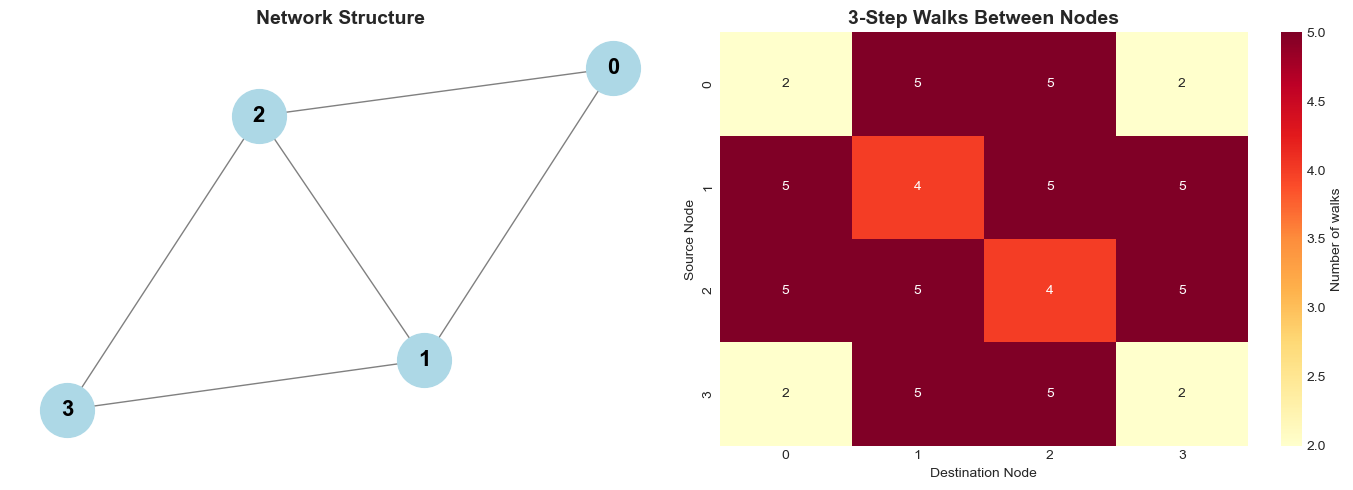

In [10]:
# Example 1.3: Matrix powers and walks

def count_walks(A, max_length=5):
    """Count walks of different lengths."""
    n = A.shape[0]
    walk_matrices = [np.eye(n), A]
    
    for k in range(2, max_length + 1):
        walk_matrices.append(walk_matrices[-1] @ A)
    
    return walk_matrices

# Compute walks for simple network
walks = count_walks(A_simple, max_length=4)

print("Number of walks between nodes:\n")
for k in range(len(walks)):
    print(f"Walks of length {k}:")
    print(walks[k].astype(int))
    print(f"Total walks: {walks[k].sum():.0f}\n")

# Visualize the network
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Network visualization
G = nx.from_numpy_array(A_simple)
pos = nx.spring_layout(G, seed=42)
nx.draw(G, pos, ax=axes[0], with_labels=True, node_color='lightblue', 
        node_size=1500, font_size=16, font_weight='bold', edge_color='gray')
axes[0].set_title('Network Structure', fontsize=14, fontweight='bold')

# Heatmap of 3-step walks
sns.heatmap(walks[3], annot=True, fmt='.0f', cmap='YlOrRd', 
            ax=axes[1], cbar_kws={'label': 'Number of walks'})
axes[1].set_title('3-Step Walks Between Nodes', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Destination Node')
axes[1].set_ylabel('Source Node')

plt.tight_layout()
plt.show()

---
## Part 2: Eigenvalue Decomposition and Spectral Properties

### 2.1 Eigenvalues and Eigenvectors: Definition and Interpretation

**Definition:** For a matrix $\mathbf{A}$, an eigenvector $\mathbf{v}$ and eigenvalue $\lambda$ satisfy:
$$
\mathbf{A} \mathbf{v} = \lambda \mathbf{v}
$$

**Spectral Theorem:** For symmetric matrices (undirected networks), eigenvalues are real and eigenvectors are orthogonal:
$$
\mathbf{A} = \mathbf{Q} \mathbf{\Lambda} \mathbf{Q}^T = \sum_{i=1}^n \lambda_i \mathbf{q}_i \mathbf{q}_i^T
$$

where $\mathbf{Q} = [\mathbf{q}_1, \ldots, \mathbf{q}_n]$ are orthonormal eigenvectors.

**Key Spectral Properties:**
1. **Largest eigenvalue** $\lambda_1$ (spectral radius): related to network connectivity
2. **Eigenvector centrality:** First eigenvector $\mathbf{q}_1$ identifies important nodes
3. **Spectral gap:** $\lambda_1 - \lambda_2$ measures network robustness
4. **Trace:** $\text{tr}(\mathbf{A}) = \sum_i \lambda_i = \sum_i A_{ii}$ (number of self-loops)
5. **Determinant:** $\det(\mathbf{A}) = \prod_i \lambda_i$

**Perron-Frobenius Theorem:** For non-negative irreducible matrices:
- Largest eigenvalue $\lambda_1 > 0$ is simple (multiplicity 1)
- Corresponding eigenvector has all positive entries
- $\lambda_1 = \rho(\mathbf{A})$ = spectral radius

In [13]:
# Example 2.1: Eigenvalue decomposition

def spectral_decomposition(A):
    """Compute eigendecomposition and verify reconstruction."""
    # For symmetric matrices, use eigvalsh (faster and more accurate)
    if np.allclose(A, A.T):
        eigenvalues, eigenvectors = linalg.eigh(A)
    else:
        eigenvalues, eigenvectors = linalg.eig(A)
        eigenvalues = eigenvalues.real
        eigenvectors = eigenvectors.real
    
    # Sort by eigenvalue magnitude (descending)
    idx = np.argsort(eigenvalues)[::-1]
    eigenvalues = eigenvalues[idx]
    eigenvectors = eigenvectors[:, idx]
    
    return eigenvalues, eigenvectors

# Decompose simple network
eigenvalues, eigenvectors = spectral_decomposition(A_simple)

print("Eigenvalues (sorted descending):")
print(eigenvalues)
print(f"\nSpectral radius (largest eigenvalue): {eigenvalues[0]:.4f}")
print(f"Spectral gap (λ₁ - λ₂): {eigenvalues[0] - eigenvalues[1]:.4f}")

print("\nEigenvectors (columns):")
print(eigenvectors)

# Verify reconstruction
Lambda = np.diag(eigenvalues)
A_reconstructed = eigenvectors @ Lambda @ eigenvectors.T
print(f"\nReconstruction error: {np.linalg.norm(A_simple - A_reconstructed):.2e}")

# Verify eigenvector property for first eigenpair
v1 = eigenvectors[:, 0]
lambda1 = eigenvalues[0]
Av1 = A_simple @ v1
lambda_v1 = lambda1 * v1

print(f"\nVerification: A·v₁ = λ₁·v₁")
print(f"A·v₁ = {Av1}")
print(f"λ₁·v₁ = {lambda_v1}")
print(f"Error: {np.linalg.norm(Av1 - lambda_v1):.2e}")

Eigenvalues (sorted descending):
[ 2.56155281e+00  2.22044605e-15 -1.00000000e+00 -1.56155281e+00]

Spectral radius (largest eigenvalue): 2.5616
Spectral gap (λ₁ - λ₂): 2.5616

Eigenvectors (columns):
[[-4.35162146e-01  7.07106781e-01  0.00000000e+00  5.57345410e-01]
 [-5.57345410e-01  5.17014681e-16 -7.07106781e-01 -4.35162146e-01]
 [-5.57345410e-01  7.39059286e-16  7.07106781e-01 -4.35162146e-01]
 [-4.35162146e-01 -7.07106781e-01  2.22044605e-16  5.57345410e-01]]

Reconstruction error: 5.79e-15

Verification: A·v₁ = λ₁·v₁
A·v₁ = [-1.11469082 -1.4276697  -1.4276697  -1.11469082]
λ₁·v₁ = [-1.11469082 -1.4276697  -1.4276697  -1.11469082]
Error: 1.22e-15


### 2.2 Eigenvector Centrality

**Definition:** Eigenvector centrality assigns scores to nodes based on the principle that connections to high-scoring nodes contribute more than connections to low-scoring nodes.

**Mathematical Formulation:**
$$
x_i = \frac{1}{\lambda} \sum_{j=1}^n A_{ij} x_j
$$

or in matrix form: $\mathbf{x} = \frac{1}{\lambda} \mathbf{A} \mathbf{x}$

This is the eigenvector equation with eigenvalue $\lambda$. The solution is the eigenvector corresponding to the largest eigenvalue $\lambda_1$ (by Perron-Frobenius theorem).

**Properties:**
- All centrality scores are non-negative
- Typically normalized so $\sum_i x_i^2 = 1$ or $\max_i x_i = 1$
- Captures both direct connections and indirect influence
- For directed networks, can compute left (in-centrality) and right (out-centrality) eigenvectors

**Financial Interpretation:**
- Nodes with high eigenvector centrality are well-connected to other well-connected nodes
- In interbank networks: identifies systemically important institutions
- In trade networks: identifies key trading hubs
- In ownership networks: identifies ultimate controllers

Eigenvector Centrality Scores:
Node 0: 0.7808
Node 1: 1.0000
Node 2: 1.0000
Node 3: 0.7808

Dominant eigenvalue: 2.5616


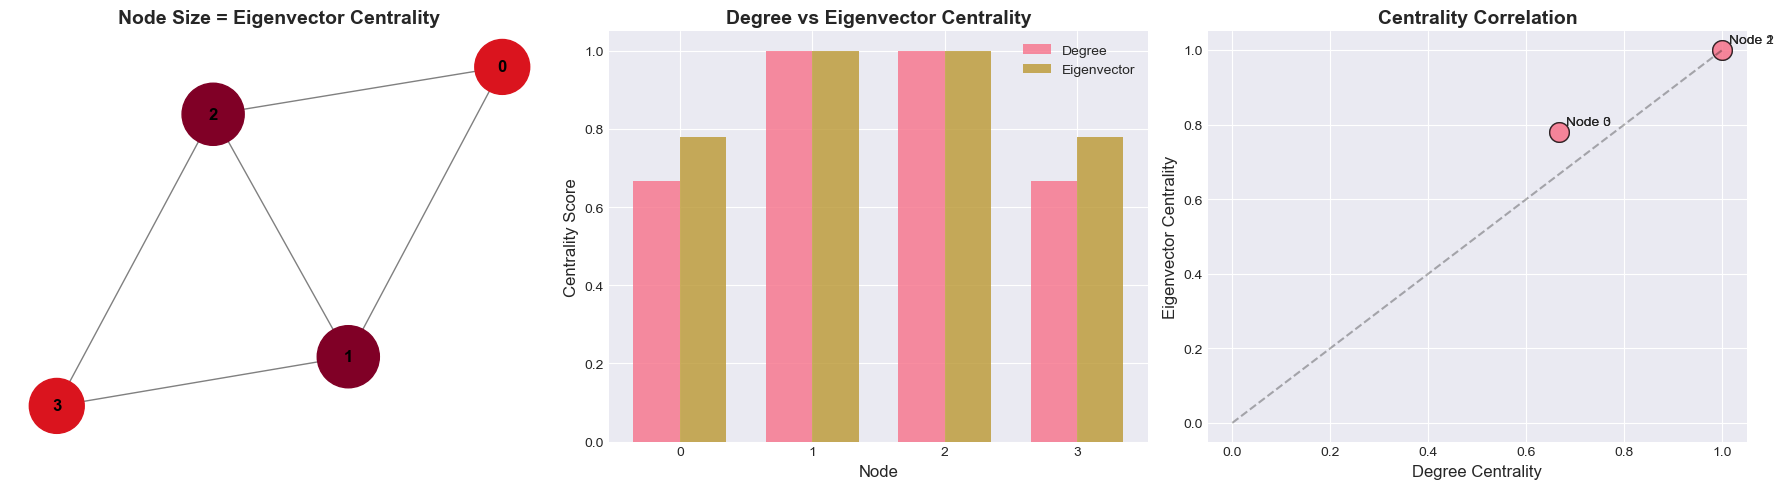

In [16]:
# Example 2.2: Computing eigenvector centrality

def eigenvector_centrality(A, normalize=True):
    """Compute eigenvector centrality."""
    eigenvalues, eigenvectors = spectral_decomposition(A)
    
    # Take eigenvector corresponding to largest eigenvalue
    centrality = np.abs(eigenvectors[:, 0])
    
    if normalize:
        centrality = centrality / centrality.max()
    
    return centrality, eigenvalues[0]

# Compute for simple network
ec, lambda1 = eigenvector_centrality(A_simple)

print("Eigenvector Centrality Scores:")
for i, score in enumerate(ec):
    print(f"Node {i}: {score:.4f}")

print(f"\nDominant eigenvalue: {lambda1:.4f}")

# Compare with degree centrality
degree_centrality = A_simple.sum(axis=1) / A_simple.sum(axis=1).max()

# Visualization
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Network with eigenvector centrality
G = nx.from_numpy_array(A_simple)
pos = nx.spring_layout(G, seed=42)
node_sizes = ec * 2000
nx.draw(G, pos, ax=axes[0], with_labels=True, node_color=ec, 
        node_size=node_sizes, font_size=12, font_weight='bold', 
        cmap='YlOrRd', edge_color='gray', vmin=0, vmax=1)
axes[0].set_title('Node Size = Eigenvector Centrality', fontsize=14, fontweight='bold')

# Bar comparison
x = np.arange(len(ec))
width = 0.35
axes[1].bar(x - width/2, degree_centrality, width, label='Degree', alpha=0.8)
axes[1].bar(x + width/2, ec, width, label='Eigenvector', alpha=0.8)
axes[1].set_xlabel('Node', fontsize=12)
axes[1].set_ylabel('Centrality Score', fontsize=12)
axes[1].set_title('Degree vs Eigenvector Centrality', fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].set_xticks(x)

# Scatter plot
axes[2].scatter(degree_centrality, ec, s=200, alpha=0.6, edgecolors='black')
for i, txt in enumerate(range(len(ec))):
    axes[2].annotate(f'Node {txt}', (degree_centrality[i], ec[i]), 
                     xytext=(5, 5), textcoords='offset points', fontsize=10)
axes[2].set_xlabel('Degree Centrality', fontsize=12)
axes[2].set_ylabel('Eigenvector Centrality', fontsize=12)
axes[2].set_title('Centrality Correlation', fontsize=14, fontweight='bold')
axes[2].plot([0, 1], [0, 1], 'k--', alpha=0.3)

plt.tight_layout()
plt.show()

### 2.3 Spectral Properties and Network Characteristics

The spectrum of the adjacency matrix reveals important structural properties:

**1. Network Density:**
$$
\text{Density} = \frac{2|E|}{n(n-1)} \approx \frac{\lambda_1}{n}
$$

**2. Clustering and Triangles:**
$$
\text{Number of triangles} = \frac{1}{6} \text{tr}(\mathbf{A}^3) = \frac{1}{6} \sum_{i=1}^n \lambda_i^3
$$

**3. Bipartiteness:** A network is bipartite iff its spectrum is symmetric around zero.

**4. Algebraic Connectivity:** Second smallest eigenvalue of Laplacian $\lambda_2(\mathbf{L})$ (Fiedler value)
- Measures how well-connected the network is
- $\lambda_2 = 0$ iff network is disconnected
- Larger $\lambda_2$ → harder to partition into disconnected components

**5. Random Walk Return Time:** Expected return time to a node scales as $1/\lambda_1$


Spectral Analysis: Simple Network
Number of nodes: 4
Number of edges: 5
Network density: 0.8333

Adjacency Spectrum:
  Spectral radius (λ₁): 2.5616
  Spectral gap (λ₁ - λ₂): 2.5616
  All eigenvalues: [ 2.56155281e+00  2.22044605e-15 -1.00000000e+00 -1.56155281e+00]

Laplacian Spectrum:
  Algebraic connectivity (λ₂): 2.0000
  All eigenvalues: [-2.77555756e-16  2.00000000e+00  4.00000000e+00  4.00000000e+00]

Triangles:
  Count (direct): 2
  Count (spectral): 2


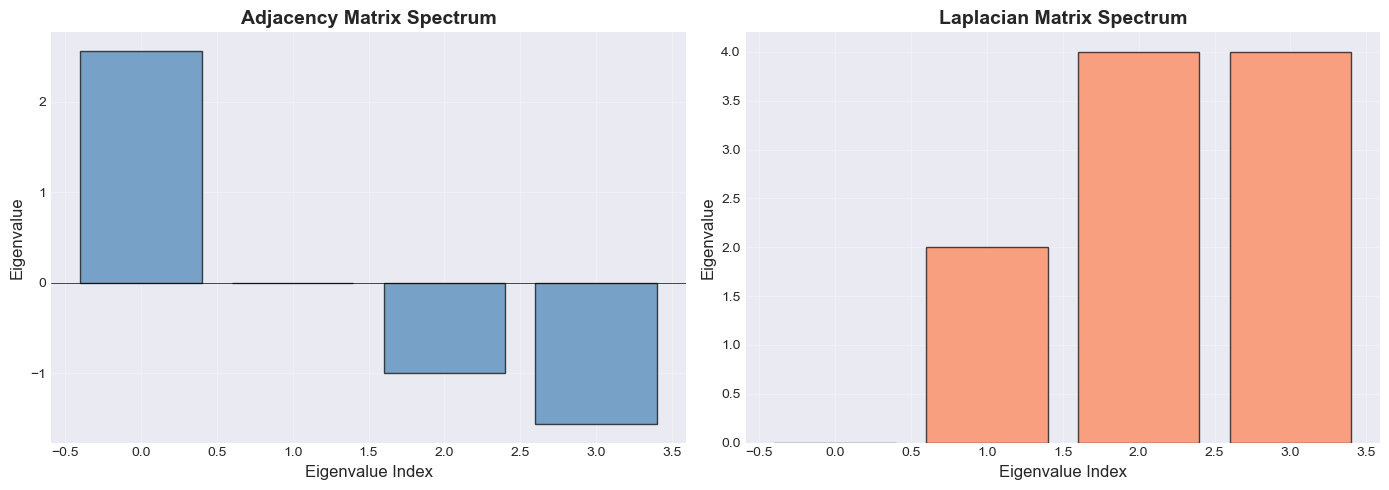

In [19]:
# Example 2.3: Spectral properties and network characteristics

def analyze_spectrum(A, name="Network"):
    """Comprehensive spectral analysis."""
    n = A.shape[0]
    
    # Adjacency spectrum
    eigenvalues_A, _ = spectral_decomposition(A)
    
    # Laplacian spectrum
    L = compute_laplacian(A)
    eigenvalues_L = np.sort(linalg.eigvalsh(L))
    
    # Compute properties
    num_edges = A.sum() / 2  # For undirected
    density = 2 * num_edges / (n * (n - 1))
    spectral_radius = eigenvalues_A[0]
    spectral_gap = eigenvalues_A[0] - eigenvalues_A[1]
    algebraic_connectivity = eigenvalues_L[1]
    
    # Number of triangles
    A3 = np.linalg.matrix_power(A, 3)
    num_triangles = np.trace(A3) / 6
    num_triangles_spectral = np.sum(eigenvalues_A**3) / 6
    
    print(f"\n{'='*60}")
    print(f"Spectral Analysis: {name}")
    print(f"{'='*60}")
    print(f"Number of nodes: {n}")
    print(f"Number of edges: {num_edges:.0f}")
    print(f"Network density: {density:.4f}")
    print(f"\nAdjacency Spectrum:")
    print(f"  Spectral radius (λ₁): {spectral_radius:.4f}")
    print(f"  Spectral gap (λ₁ - λ₂): {spectral_gap:.4f}")
    print(f"  All eigenvalues: {eigenvalues_A}")
    print(f"\nLaplacian Spectrum:")
    print(f"  Algebraic connectivity (λ₂): {algebraic_connectivity:.4f}")
    print(f"  All eigenvalues: {eigenvalues_L}")
    print(f"\nTriangles:")
    print(f"  Count (direct): {num_triangles:.0f}")
    print(f"  Count (spectral): {num_triangles_spectral:.0f}")
    
    return eigenvalues_A, eigenvalues_L

# Analyze simple network
eig_A, eig_L = analyze_spectrum(A_simple, "Simple Network")

# Create visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Adjacency spectrum
axes[0].bar(range(len(eig_A)), eig_A, color='steelblue', alpha=0.7, edgecolor='black')
axes[0].axhline(y=0, color='k', linestyle='-', linewidth=0.5)
axes[0].set_xlabel('Eigenvalue Index', fontsize=12)
axes[0].set_ylabel('Eigenvalue', fontsize=12)
axes[0].set_title('Adjacency Matrix Spectrum', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3)

# Laplacian spectrum
axes[1].bar(range(len(eig_L)), eig_L, color='coral', alpha=0.7, edgecolor='black')
axes[1].axhline(y=0, color='k', linestyle='-', linewidth=0.5)
axes[1].set_xlabel('Eigenvalue Index', fontsize=12)
axes[1].set_ylabel('Eigenvalue', fontsize=12)
axes[1].set_title('Laplacian Matrix Spectrum', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

---
## Part 3: Financial Application - Identifying Systemically Important Banks

### 3.1 Problem Statement

**Research Question:** Which financial institutions pose the greatest systemic risk in the interbank lending network?

**Context:** During the 2008 financial crisis, the failure of Lehman Brothers demonstrated that interconnectedness amplifies systemic risk. Not all banks are equally important - those that are highly connected to other important banks can trigger cascading failures.

**Data:** We analyze a stylized interbank lending network based on 2008 crisis patterns, where:
- Nodes = Banks
- Edges = Lending relationships
- Weights = Loan amounts (billions USD)

### 3.2 Methodology: Eigenvector Centrality for Systemic Risk

**Why Eigenvector Centrality?**
1. Captures direct and indirect exposures
2. Banks connected to systemically important banks are themselves systemically important
3. Recursive definition naturally identifies "too-interconnected-to-fail" institutions

**Mathematical Framework:**
$$
\text{Systemic Importance}_i = \frac{1}{\lambda_1} \sum_{j=1}^n A_{ij} \cdot \text{Systemic Importance}_j
$$

**Comparison with Alternative Measures:**
- **Degree centrality:** Only counts number of connections (ignores quality)
- **Betweenness centrality:** Focuses on bridges (may miss dense clusters)
- **Eigenvector centrality:** Weighs connections by importance (captures systemic risk)

In [22]:
# Example 3.1: Create stylized interbank network

# Bank names (stylized for demonstration)
bank_names = [
    'Mega Bank', 'Investment Corp', 'Regional Trust', 'Global Finance',
    'Commercial Bank', 'Investment Partners', 'Treasury Holdings', 'Credit Union',
    'Savings & Loan', 'Financial Services', 'Capital Markets', 'Retail Banking'
]

n_banks = len(bank_names)

# Create interbank lending network (directed, weighted)
# Simulating 2008-style interconnected structure
np.random.seed(42)

# Core banks (highly interconnected)
core_banks = [0, 1, 3, 10]  # Mega Bank, Investment Corp, Global Finance, Capital Markets

# Initialize adjacency matrix
A_interbank = np.zeros((n_banks, n_banks))

# Create core interconnections (higher weights)
for i in core_banks:
    for j in core_banks:
        if i != j:
            A_interbank[i, j] = np.random.uniform(10, 30)

# Connections from core to periphery
for i in core_banks:
    for j in range(n_banks):
        if j not in core_banks and np.random.random() > 0.5:
            A_interbank[i, j] = np.random.uniform(2, 10)
            A_interbank[j, i] = np.random.uniform(1, 5)  # Smaller reverse flows

# Some periphery connections
for i in range(n_banks):
    for j in range(n_banks):
        if i != j and A_interbank[i, j] == 0 and np.random.random() > 0.85:
            A_interbank[i, j] = np.random.uniform(0.5, 3)

# Create DataFrame for better visualization
df_interbank = pd.DataFrame(A_interbank, index=bank_names, columns=bank_names)

print("Interbank Lending Network (Billions USD)")
print("="*80)
print(df_interbank.round(2))

# Basic network statistics
total_lending = A_interbank.sum()
density = np.count_nonzero(A_interbank) / (n_banks * (n_banks - 1))

print(f"\nNetwork Statistics:")
print(f"Total interbank lending: ${total_lending:.1f}B")
print(f"Network density: {density:.2%}")
print(f"Number of lending relationships: {np.count_nonzero(A_interbank)}")

Interbank Lending Network (Billions USD)
                     Mega Bank  Investment Corp  Regional Trust  \
Mega Bank                 0.00            17.49            3.70   
Investment Corp          21.97             0.00            2.37   
Regional Trust            1.73             3.43            0.00   
Global Finance           11.16            27.32            0.00   
Commercial Bank           0.00             0.00            0.00   
Investment Partners       0.00             0.00            0.00   
Treasury Holdings         2.16             4.23            1.30   
Credit Union              2.17             0.00            0.00   
Savings & Loan            0.00             0.00            0.00   
Financial Services        1.10             1.49            0.00   
Capital Markets          24.16            10.41            0.00   
Retail Banking            3.06             0.00            0.00   

                     Global Finance  Commercial Bank  Investment Partners  \
Mega Bank 

### 3.3 Analysis: Computing Systemic Importance Rankings

In [25]:
# Example 3.2: Compute systemic importance measures

def compute_centrality_measures(A, names):
    """Compute multiple centrality measures for comparison."""
    n = len(names)
    
    # 1. Degree centrality (in, out, total)
    out_degree = A.sum(axis=1)  # Total lending
    in_degree = A.sum(axis=0)   # Total borrowing
    total_degree = out_degree + in_degree
    
    # 2. Eigenvector centrality
    # For directed networks, use (A + A.T) or analyze separately
    A_symmetric = (A + A.T) / 2  # Symmetrized version
    eig_cent, _ = eigenvector_centrality(A_symmetric)
    
    # 3. PageRank (variant of eigenvector centrality for directed networks)
    G = nx.from_numpy_array(A, create_using=nx.DiGraph)
    pagerank = nx.pagerank(G, alpha=0.85)
    pagerank_scores = np.array([pagerank[i] for i in range(n)])
    
    # Create results DataFrame
    results = pd.DataFrame({
        'Bank': names,
        'Total Lending': out_degree,
        'Total Borrowing': in_degree,
        'Total Exposure': total_degree,
        'Eigenvector Centrality': eig_cent,
        'PageRank': pagerank_scores
    })
    
    # Normalize scores to [0, 1] for comparison
    for col in ['Total Lending', 'Total Borrowing', 'Total Exposure', 
                'Eigenvector Centrality', 'PageRank']:
        results[f'{col} (Normalized)'] = results[col] / results[col].max()
    
    return results

# Compute measures
centrality_results = compute_centrality_measures(A_interbank, bank_names)

# Display top banks by eigenvector centrality
print("\nSystemic Importance Rankings (by Eigenvector Centrality)")
print("="*80)
top_banks = centrality_results.nlargest(5, 'Eigenvector Centrality')
print(top_banks[['Bank', 'Total Exposure', 'Eigenvector Centrality', 'PageRank']].to_string(index=False))

# Full comparison table
print("\n\nComplete Centrality Analysis")
print("="*80)
display_cols = ['Bank', 'Total Lending', 'Total Borrowing', 
                'Eigenvector Centrality (Normalized)', 'PageRank (Normalized)']
print(centrality_results[display_cols].sort_values(
    'Eigenvector Centrality (Normalized)', ascending=False
).round(4).to_string(index=False))


Systemic Importance Rankings (by Eigenvector Centrality)
             Bank  Total Exposure  Eigenvector Centrality  PageRank
   Global Finance      172.303536                1.000000  0.199283
        Mega Bank      154.525513                0.966208  0.178312
  Capital Markets      151.011761                0.954829  0.169554
  Investment Corp      132.267495                0.823551  0.161020
Treasury Holdings       34.024912                0.212709  0.059184


Complete Centrality Analysis
               Bank  Total Lending  Total Borrowing  Eigenvector Centrality (Normalized)  PageRank (Normalized)
     Global Finance        85.9357          86.3679                               1.0000                 1.0000
          Mega Bank        87.0126          67.5129                               0.9662                 0.8948
    Capital Markets        80.1307          70.8810                               0.9548                 0.8508
    Investment Corp        67.8896          64.3779    

### 3.4 Visualization and Interpretation

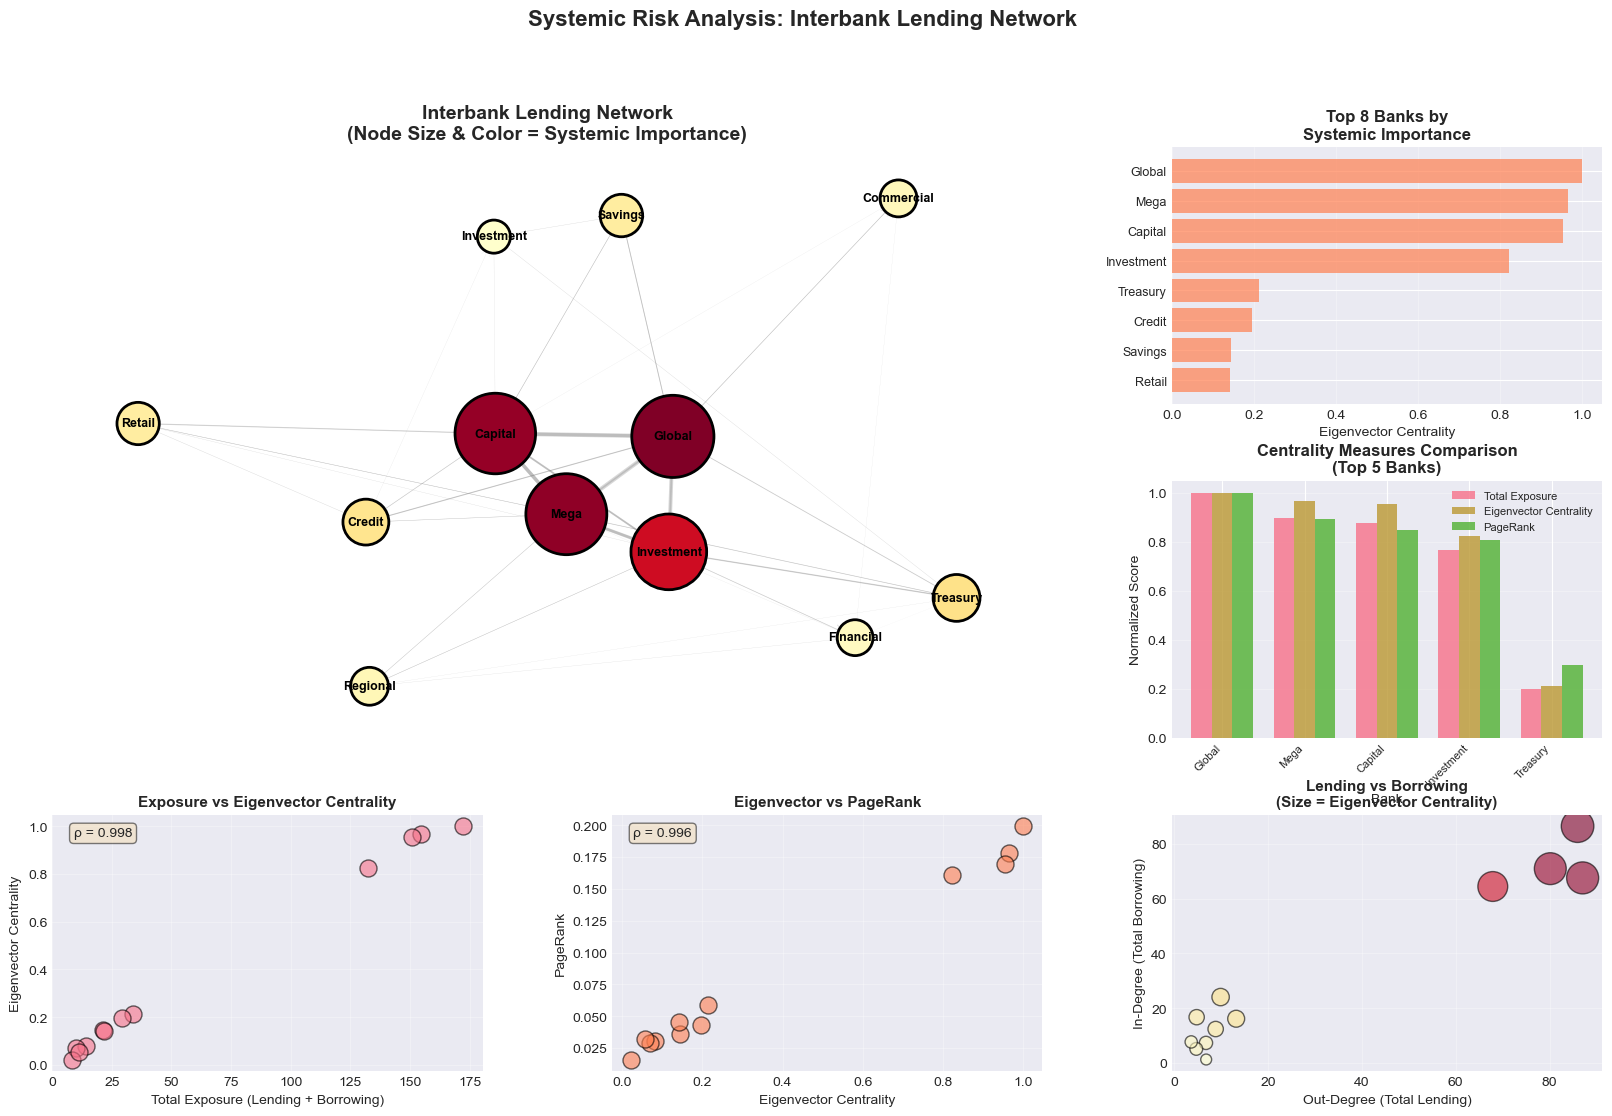

In [28]:
# Example 3.3: Visualize systemic importance

# Create network visualization
fig = plt.figure(figsize=(20, 12))
gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

# 1. Network graph with node sizes = eigenvector centrality
ax1 = fig.add_subplot(gs[0:2, 0:2])
G = nx.from_numpy_array(A_interbank, create_using=nx.DiGraph)
pos = nx.spring_layout(G, k=2, iterations=50, seed=42)

eig_cent = centrality_results['Eigenvector Centrality'].values
node_sizes = eig_cent * 3000 + 500
node_colors = eig_cent

# Draw edges with weights
edges = G.edges()
weights = [G[u][v]['weight'] for u, v in edges]
max_weight = max(weights)
edge_widths = [3 * w / max_weight for w in weights]

nx.draw_networkx_edges(G, pos, ax=ax1, edge_color='gray', 
                       width=edge_widths, alpha=0.3, 
                       arrows=True, arrowsize=15, arrowstyle='->')

nx.draw_networkx_nodes(G, pos, ax=ax1, node_color=node_colors, 
                       node_size=node_sizes, cmap='YlOrRd', 
                       edgecolors='black', linewidths=2)

# Add labels
labels = {i: name.split()[0] for i, name in enumerate(bank_names)}  # Shortened names
nx.draw_networkx_labels(G, pos, labels, ax=ax1, font_size=9, font_weight='bold')

ax1.set_title('Interbank Lending Network\n(Node Size & Color = Systemic Importance)', 
              fontsize=14, fontweight='bold')
ax1.axis('off')

# 2. Ranking comparison
ax2 = fig.add_subplot(gs[0, 2])
top_n = 8
top_banks_plot = centrality_results.nlargest(top_n, 'Eigenvector Centrality')
y_pos = np.arange(top_n)

ax2.barh(y_pos, top_banks_plot['Eigenvector Centrality'], color='coral', alpha=0.7)
ax2.set_yticks(y_pos)
ax2.set_yticklabels([name.split()[0] for name in top_banks_plot['Bank']], fontsize=9)
ax2.invert_yaxis()
ax2.set_xlabel('Eigenvector Centrality', fontsize=10)
ax2.set_title(f'Top {top_n} Banks by\nSystemic Importance', fontsize=12, fontweight='bold')
ax2.grid(axis='x', alpha=0.3)

# 3. Centrality measures comparison
ax3 = fig.add_subplot(gs[1, 2])
measures = ['Total Exposure (Normalized)', 'Eigenvector Centrality (Normalized)', 
            'PageRank (Normalized)']
top_5 = centrality_results.nlargest(5, 'Eigenvector Centrality')

x_pos = np.arange(len(top_5))
width = 0.25

for i, measure in enumerate(measures):
    ax3.bar(x_pos + i*width, top_5[measure], width, 
            label=measure.replace(' (Normalized)', ''), alpha=0.8)

ax3.set_xlabel('Bank', fontsize=10)
ax3.set_ylabel('Normalized Score', fontsize=10)
ax3.set_title('Centrality Measures Comparison\n(Top 5 Banks)', fontsize=12, fontweight='bold')
ax3.set_xticks(x_pos + width)
ax3.set_xticklabels([name.split()[0] for name in top_5['Bank']], 
                     rotation=45, ha='right', fontsize=8)
ax3.legend(fontsize=8, loc='upper right')
ax3.grid(axis='y', alpha=0.3)

# 4. Correlation scatter plots
ax4 = fig.add_subplot(gs[2, 0])
ax4.scatter(centrality_results['Total Exposure'], 
            centrality_results['Eigenvector Centrality'],
            s=150, alpha=0.6, edgecolors='black')
ax4.set_xlabel('Total Exposure (Lending + Borrowing)', fontsize=10)
ax4.set_ylabel('Eigenvector Centrality', fontsize=10)
ax4.set_title('Exposure vs Eigenvector Centrality', fontsize=11, fontweight='bold')
ax4.grid(True, alpha=0.3)

# Add correlation coefficient
corr = np.corrcoef(centrality_results['Total Exposure'], 
                   centrality_results['Eigenvector Centrality'])[0, 1]
ax4.text(0.05, 0.95, f'ρ = {corr:.3f}', transform=ax4.transAxes, 
         fontsize=10, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

ax5 = fig.add_subplot(gs[2, 1])
ax5.scatter(centrality_results['Eigenvector Centrality'], 
            centrality_results['PageRank'],
            s=150, alpha=0.6, edgecolors='black', color='coral')
ax5.set_xlabel('Eigenvector Centrality', fontsize=10)
ax5.set_ylabel('PageRank', fontsize=10)
ax5.set_title('Eigenvector vs PageRank', fontsize=11, fontweight='bold')
ax5.grid(True, alpha=0.3)

corr2 = np.corrcoef(centrality_results['Eigenvector Centrality'], 
                    centrality_results['PageRank'])[0, 1]
ax5.text(0.05, 0.95, f'ρ = {corr2:.3f}', transform=ax5.transAxes, 
         fontsize=10, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# 5. Degree distribution
ax6 = fig.add_subplot(gs[2, 2])
out_degrees = A_interbank.sum(axis=1)
in_degrees = A_interbank.sum(axis=0)

ax6.scatter(out_degrees, in_degrees, s=eig_cent*500+50, 
            c=eig_cent, cmap='YlOrRd', alpha=0.6, edgecolors='black')
ax6.set_xlabel('Out-Degree (Total Lending)', fontsize=10)
ax6.set_ylabel('In-Degree (Total Borrowing)', fontsize=10)
ax6.set_title('Lending vs Borrowing\n(Size = Eigenvector Centrality)', 
              fontsize=11, fontweight='bold')
ax6.grid(True, alpha=0.3)

plt.suptitle('Systemic Risk Analysis: Interbank Lending Network', 
             fontsize=16, fontweight='bold', y=0.995)

plt.show()

### 3.5 Interpretation and Policy Implications

**Key Findings:**

1. **Systemic Importance ≠ Size:** Banks with high eigenvector centrality are not necessarily the largest lenders, but are connected to other important institutions.

2. **Core-Periphery Structure:** The network exhibits a core of highly interconnected banks (high eigenvector centrality) and a periphery of less connected institutions.

3. **Contagion Risk:** Banks with high eigenvector centrality are:
   - More vulnerable to shocks from their counterparties
   - More likely to propagate failures throughout the system
   - Critical nodes whose failure could trigger cascades

4. **Comparison of Measures:**
   - **Total exposure** captures direct risk but misses network effects
   - **Eigenvector centrality** captures indirect exposures and feedback loops
   - **PageRank** adds damping factor (probability of "teleportation") - useful for directed networks

**Policy Recommendations:**

1. **Enhanced Supervision:** Banks with high eigenvector centrality should face:
   - More frequent stress tests
   - Higher capital requirements (systemic risk buffer)
   - Stricter liquidity requirements

2. **Systemic Risk Indicators:** Regulators should monitor:
   - Changes in eigenvector centrality over time
   - Formation of new core interconnections
   - Concentration of exposures

3. **Network Resilience:** Policies to improve resilience:
   - Diversification requirements for interbank exposures
   - Central counterparty clearing for certain exposures
   - Resolution mechanisms for systemically important institutions

4. **Crisis Management:** During stress:
   - Prioritize liquidity support to high-centrality banks
   - Monitor contagion pathways using network structure
   - Coordinate interventions to break transmission chains

---
## Part 4: Advanced Topics and Extensions

### 4.1 Time-Varying Networks

**Challenge:** Financial networks are dynamic - relationships form and dissolve, weights change over time.

**Approach:** Track eigenvector centrality over rolling windows to identify:
- Changes in systemic importance
- Emerging risks
- Crisis periods (increased concentration)

Simulating network dynamics through crisis...


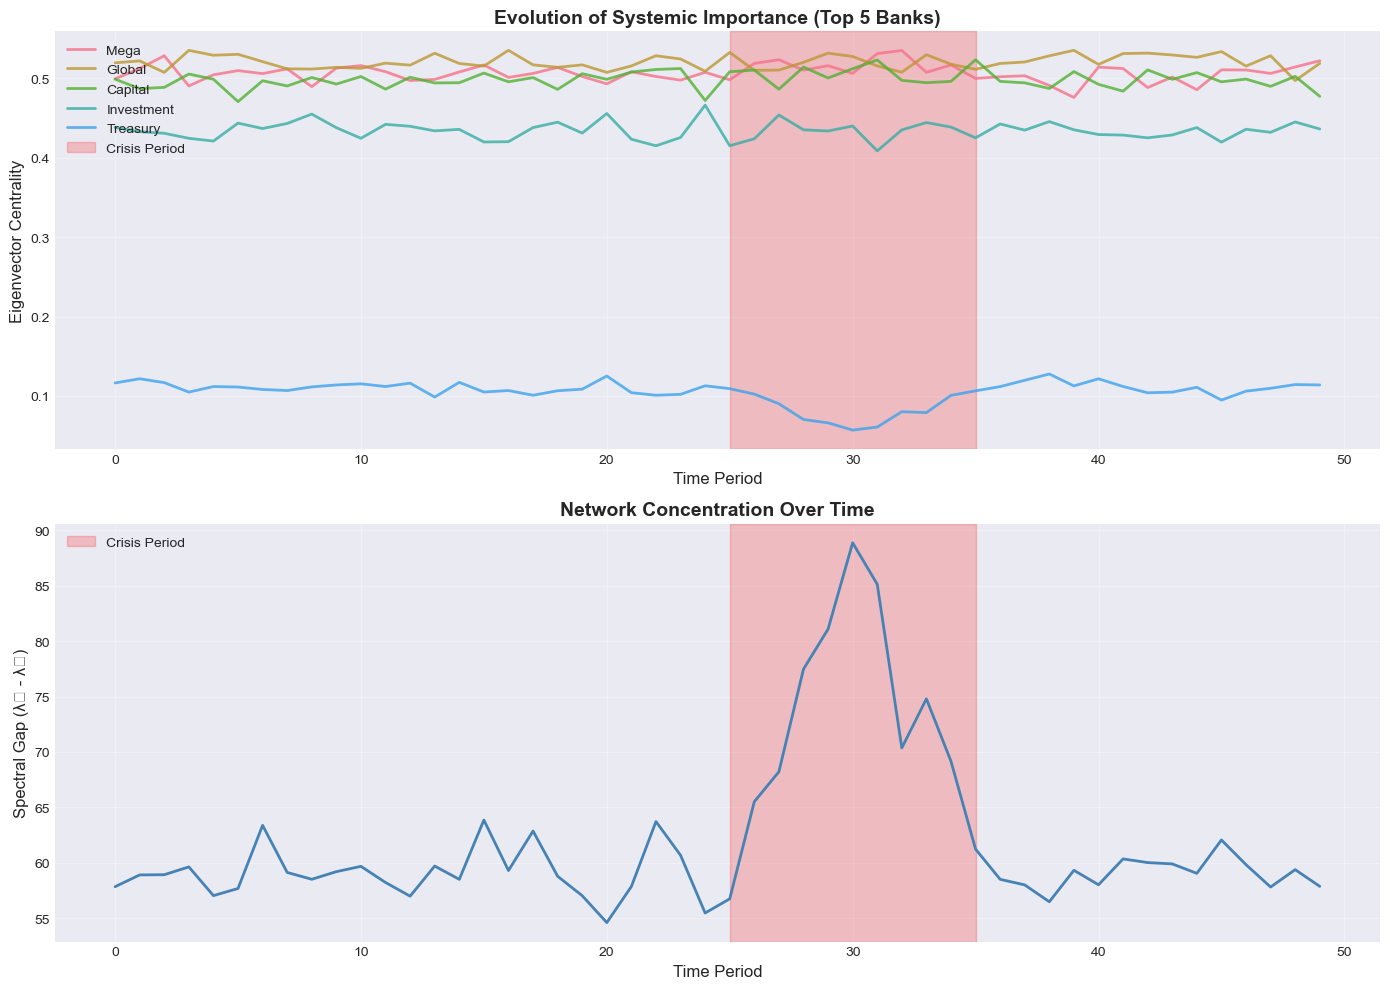


Crisis Period Analysis:
Average spectral gap:
  Pre-crisis:   59.104
  During crisis: 73.732 (+24.7%)
  Post-crisis:   59.193 (+0.1%)

Interpretation: Larger spectral gap indicates increased concentration
of importance in core banks during crisis.


In [30]:
# Example 4.1: Simulating time-varying centrality

def simulate_crisis_dynamics(A_baseline, n_periods=50, crisis_start=25, crisis_duration=10):
    """
    Simulate network dynamics through normal and crisis periods.
    Crisis = increased concentration in core banks, withdrawal from periphery.
    """
    n = A_baseline.shape[0]
    centralities = np.zeros((n_periods, n))
    spectral_gaps = np.zeros(n_periods)
    
    for t in range(n_periods):
        # Base network with noise
        A_t = A_baseline.copy()
        A_t = A_t * (1 + np.random.normal(0, 0.1, A_t.shape))
        A_t = np.maximum(A_t, 0)  # Keep non-negative
        
        # Crisis period: flight to quality (core strengthens, periphery weakens)
        if crisis_start <= t < crisis_start + crisis_duration:
            crisis_intensity = 1 - abs(t - (crisis_start + crisis_duration/2)) / (crisis_duration/2)
            
            # Strengthen core connections
            for i in core_banks:
                for j in core_banks:
                    if i != j:
                        A_t[i, j] *= (1 + 0.5 * crisis_intensity)
            
            # Weaken periphery connections
            for i in range(n):
                if i not in core_banks:
                    A_t[i, :] *= (1 - 0.3 * crisis_intensity)
                    A_t[:, i] *= (1 - 0.3 * crisis_intensity)
        
        # Compute centrality
        A_sym = (A_t + A_t.T) / 2
        cent, _ = eigenvector_centrality(A_sym, normalize=False)
        centralities[t, :] = cent
        
        # Compute spectral gap
        eigenvalues, _ = spectral_decomposition(A_sym)
        spectral_gaps[t] = eigenvalues[0] - eigenvalues[1]
    
    return centralities, spectral_gaps

# Run simulation
print("Simulating network dynamics through crisis...")
centralities_time, gaps_time = simulate_crisis_dynamics(A_interbank)

# Visualize
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# Plot centrality trajectories for top banks
top_indices = np.argsort(centralities_time[-1, :])[-5:][::-1]
time_axis = np.arange(centralities_time.shape[0])

for idx in top_indices:
    axes[0].plot(time_axis, centralities_time[:, idx], 
                 label=bank_names[idx].split()[0], linewidth=2, alpha=0.8)

axes[0].axvspan(25, 35, alpha=0.2, color='red', label='Crisis Period')
axes[0].set_xlabel('Time Period', fontsize=12)
axes[0].set_ylabel('Eigenvector Centrality', fontsize=12)
axes[0].set_title('Evolution of Systemic Importance (Top 5 Banks)', 
                  fontsize=14, fontweight='bold')
axes[0].legend(loc='upper left', fontsize=10)
axes[0].grid(True, alpha=0.3)

# Plot spectral gap (measure of network concentration)
axes[1].plot(time_axis, gaps_time, linewidth=2, color='steelblue')
axes[1].axvspan(25, 35, alpha=0.2, color='red', label='Crisis Period')
axes[1].set_xlabel('Time Period', fontsize=12)
axes[1].set_ylabel('Spectral Gap (λ₁ - λ₂)', fontsize=12)
axes[1].set_title('Network Concentration Over Time', fontsize=14, fontweight='bold')
axes[1].legend(loc='upper left', fontsize=10)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n" + "="*70)
print("Crisis Period Analysis:")
print("="*70)
pre_crisis_gap = gaps_time[:25].mean()
crisis_gap = gaps_time[25:35].mean()
post_crisis_gap = gaps_time[35:].mean()

print(f"Average spectral gap:")
print(f"  Pre-crisis:   {pre_crisis_gap:.3f}")
print(f"  During crisis: {crisis_gap:.3f} ({(crisis_gap/pre_crisis_gap-1)*100:+.1f}%)")
print(f"  Post-crisis:   {post_crisis_gap:.3f} ({(post_crisis_gap/pre_crisis_gap-1)*100:+.1f}%)")
print("\nInterpretation: Larger spectral gap indicates increased concentration")
print("of importance in core banks during crisis.")

### 4.2 Robustness Analysis

**Question:** How does the network respond to targeted vs random node removal?

**Methodology:**
1. **Random failure:** Remove nodes randomly (operational failures)
2. **Targeted attack:** Remove highest centrality nodes (deliberate stress)
3. **Measure:** Track largest eigenvalue and algebraic connectivity

In [ ]:
# Example 4.2: Network robustness analysis

def network_robustness(A, removal_order='random', max_removals=None):
    """
    Analyze network robustness to node removal.
    Returns eigenvalues as nodes are progressively removed.
    """
    n = A.shape[0]
    if max_removals is None:
        max_removals = n // 2
    
    A_sym = (A + A.T) / 2
    
    if removal_order == 'targeted':
        # Remove nodes by eigenvector centrality
        cent, _ = eigenvector_centrality(A_sym, normalize=False)
        removal_sequence = np.argsort(cent)[::-1]
    else:
        # Random removal
        removal_sequence = np.random.permutation(n)
    
    spectral_radii = []
    algebraic_connectivities = []
    active_nodes = list(range(n))
    
    # Initial state
    eig_A, _ = spectral_decomposition(A_sym)
    L = compute_laplacian(A_sym)
    eig_L = np.sort(linalg.eigvalsh(L))
    spectral_radii.append(eig_A[0])
    algebraic_connectivities.append(eig_L[1])
    
    # Progressive removal
    for i in range(min(max_removals, len(removal_sequence))):
        node_to_remove = removal_sequence[i]
        if node_to_remove in active_nodes:
            active_nodes.remove(node_to_remove)
        
        if len(active_nodes) <= 1:
            break
        
        # Create subnetwork
        A_sub = A_sym[np.ix_(active_nodes, active_nodes)]
        
        # Compute metrics
        eig_A, _ = spectral_decomposition(A_sub)
        L_sub = compute_laplacian(A_sub)
        eig_L = np.sort(linalg.eigvalsh(L_sub))
        
        spectral_radii.append(eig_A[0])
        algebraic_connectivities.append(eig_L[1] if len(eig_L) > 1 else 0)
    
    return np.array(spectral_radii), np.array(algebraic_connectivities)

# Run robustness analysis
print("Running robustness analysis...")
n_removals = 8
n_random_trials = 20

# Targeted attack
sr_targeted, ac_targeted = network_robustness(A_interbank, 'targeted', n_removals)

# Random failures (multiple trials)
sr_random_all = []
ac_random_all = []
for trial in range(n_random_trials):
    sr, ac = network_robustness(A_interbank, 'random', n_removals)
    sr_random_all.append(sr)
    ac_random_all.append(ac)

sr_random_mean = np.mean(sr_random_all, axis=0)
sr_random_std = np.std(sr_random_all, axis=0)
ac_random_mean = np.mean(ac_random_all, axis=0)
ac_random_std = np.std(ac_random_all, axis=0)

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

x_axis = np.arange(len(sr_targeted))

# Spectral radius
axes[0].plot(x_axis, sr_targeted, 'r-o', linewidth=2, label='Targeted Attack', markersize=8)
axes[0].plot(x_axis, sr_random_mean, 'b-s', linewidth=2, label='Random Failure', markersize=8)
axes[0].fill_between(x_axis, 
                     sr_random_mean - sr_random_std,
                     sr_random_mean + sr_random_std,
                     alpha=0.2, color='blue')
axes[0].set_xlabel('Number of Nodes Removed', fontsize=12)
axes[0].set_ylabel('Spectral Radius (λ₁)', fontsize=12)
axes[0].set_title('Network Connectivity Degradation', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3)

# Algebraic connectivity
axes[1].plot(x_axis, ac_targeted, 'r-o', linewidth=2, label='Targeted Attack', markersize=8)
axes[1].plot(x_axis, ac_random_mean, 'b-s', linewidth=2, label='Random Failure', markersize=8)
axes[1].fill_between(x_axis, 
                     ac_random_mean - ac_random_std,
                     ac_random_mean + ac_random_std,
                     alpha=0.2, color='blue')
axes[1].set_xlabel('Number of Nodes Removed', fontsize=12)
axes[1].set_ylabel('Algebraic Connectivity (λ₂)', fontsize=12)
axes[1].set_title('Network Fragmentation Risk', fontsize=14, fontweight='bold')
axes[1].legend(fontsize=11)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n" + "="*70)
print("Robustness Analysis Results:")
print("="*70)
print(f"After removing {n_removals} nodes:")
print(f"\nTargeted attack:")
print(f"  Spectral radius reduction: {(1 - sr_targeted[-1]/sr_targeted[0])*100:.1f}%")
print(f"  Algebraic connectivity reduction: {(1 - ac_targeted[-1]/ac_targeted[0])*100:.1f}%")
print(f"\nRandom failure (average):")
print(f"  Spectral radius reduction: {(1 - sr_random_mean[-1]/sr_random_mean[0])*100:.1f}%")
print(f"  Algebraic connectivity reduction: {(1 - ac_random_mean[-1]/ac_random_mean[0])*100:.1f}%")
print("\nInterpretation: Network is much more vulnerable to targeted attacks")
print("on high-centrality nodes, indicating a fragile core-periphery structure.")

---
## Summary and Key Takeaways

### Theoretical Foundations

1. **Matrix Representations:**
   - Adjacency matrix $\mathbf{A}$ encodes network structure
   - Degree matrix $\mathbf{D}$ and Laplacian $\mathbf{L} = \mathbf{D} - \mathbf{A}$
   - Matrix powers count walks: $(\mathbf{A}^k)_{ij}$ = # of k-step walks

2. **Spectral Properties:**
   - Eigenvalue decomposition: $\mathbf{A} = \mathbf{Q} \mathbf{\Lambda} \mathbf{Q}^T$
   - Largest eigenvalue $\lambda_1$ (spectral radius) measures connectivity
   - Spectral gap $\lambda_1 - \lambda_2$ indicates robustness
   - Algebraic connectivity $\lambda_2(\mathbf{L})$ measures fragmentation risk

3. **Eigenvector Centrality:**
   - Recursive importance: $x_i = \frac{1}{\lambda} \sum_j A_{ij} x_j$
   - Identifies nodes well-connected to other important nodes
   - Guaranteed to exist (Perron-Frobenius) for non-negative matrices

### Financial Applications

1. **Systemic Risk Identification:**
   - Eigenvector centrality identifies "too-interconnected-to-fail" banks
   - Captures indirect exposures and cascade potential
   - More informative than size or direct exposure metrics

2. **Network Dynamics:**
   - Crisis periods show increased concentration (higher spectral gap)
   - Flight to quality strengthens core interconnections
   - Time-varying analysis reveals emerging risks

3. **Robustness Testing:**
   - Networks vulnerable to targeted attacks on central nodes
   - Random failures have less impact (until threshold)
   - Informs regulatory stress testing and resolution planning

### Practical Considerations

1. **Data Requirements:**
   - Bilateral exposure data (often confidential)
   - Regular updates for monitoring
   - Cross-border coordination for global networks

2. **Computational Complexity:**
   - Eigendecomposition: $O(n^3)$ for dense matrices
   - Sparse matrix methods for large networks
   - Power iteration for largest eigenvalue/vector: $O(n^2)$ per iteration

3. **Model Limitations:**
   - Static analysis misses temporal dynamics
   - Assumes linear propagation (may underestimate cascades)
   - Doesn't capture behavioral responses

### Next Steps

In upcoming sessions we will explore:
- **Session 2:** Random matrix theory for noise filtering
- **Session 3:** Alternative centrality measures and their interpretations
- **Session 4:** Community detection in financial networks
- **Session 6:** Dynamic contagion models
- **Session 7:** DebtRank and advanced systemic risk measures

---
## Exercises

### Exercise 1: Matrix Properties
Create a small financial network (5-6 nodes) and:
1. Compute its adjacency matrix, degree matrix, and Laplacian
2. Verify that $\mathbf{L} = \mathbf{D} - \mathbf{A}$
3. Calculate eigenvalues and verify properties:
   - All Laplacian eigenvalues ≥ 0
   - Sum of Adjacency eigenvalues = trace
   - Product of Adjacency eigenvalues = determinant

### Exercise 2: Walk Enumeration
For your network from Exercise 1:
1. Compute $\mathbf{A}^2$ and $\mathbf{A}^3$
2. Manually verify the walk counts for specific node pairs
3. Identify which node pairs have the most 3-step paths
4. Discuss the financial interpretation of these paths

### Exercise 3: Centrality Comparison
Using real or simulated data:
1. Create an interbank network with 8-10 banks
2. Compute:
   - Degree centrality (in, out, total)
   - Eigenvector centrality
   - PageRank
3. Rank banks by each measure
4. Analyze differences: which banks rank high on one measure but not others?
5. Provide financial interpretation of the differences

### Exercise 4: Spectral Analysis
1. Generate two networks:
   - Dense core-periphery structure
   - Sparse but evenly connected structure
2. Compare their spectra (plot eigenvalues)
3. Compute spectral gap for both
4. Relate spectral properties to network structure
5. Which structure is more vulnerable to systemic risk?

### Exercise 5: Crisis Simulation (Advanced)
Extend the time-varying analysis:
1. Create a baseline interbank network
2. Simulate different crisis scenarios:
   - Liquidity shock (random reduction in connections)
   - Solvency shock (failure of specific high-centrality bank)
   - Confidence shock (flight to quality - core strengthens)
3. Track eigenvector centrality changes
4. Compare systemic risk implications of each scenario
5. Propose policy interventions based on the analysis

---
## References and Further Reading

### Core Texts
1. Newman, M. E. J. (2018). *Networks* (2nd ed.). Oxford University Press.
2. Kolaczyk, E. D., & Csárdi, G. (2020). *Statistical Analysis of Network Data with R* (2nd ed.). Springer.
3. Barabási, A. L. (2016). *Network Science*. Cambridge University Press.

### Financial Networks
4. Cont, R., Moussa, A., & Santos, E. B. (2013). Network structure and systemic risk in banking systems. In *Handbook on Systemic Risk* (pp. 327-368).
5. Acemoglu, D., Ozdaglar, A., & Tahbaz-Salehi, A. (2015). Systemic risk and stability in financial networks. *American Economic Review*, 105(2), 564-608.
6. Battiston, S., Caldarelli, G., May, R. M., Roukny, T., & Stiglitz, J. E. (2016). The price of complexity in financial networks. *Proceedings of the National Academy of Sciences*, 113(36), 10031-10036.

### Spectral Methods
7. Chung, F. R. K. (1997). *Spectral Graph Theory*. American Mathematical Society.
8. Von Luxburg, U. (2007). A tutorial on spectral clustering. *Statistics and Computing*, 17(4), 395-416.

### Systemic Risk and Regulation
9. ECB (2010). Financial networks and financial stability. *Financial Stability Review*.
10. Basel Committee on Banking Supervision (2018). Global systemically important banks: revised assessment methodology.

### Data Sources
- ECB Statistical Data Warehouse: https://sdw.ecb.europa.eu/
- BIS Statistics: https://www.bis.org/statistics/
- Federal Reserve Economic Data (FRED): https://fred.stlouisfed.org/
- European Systemic Risk Board: https://www.esrb.europa.eu/